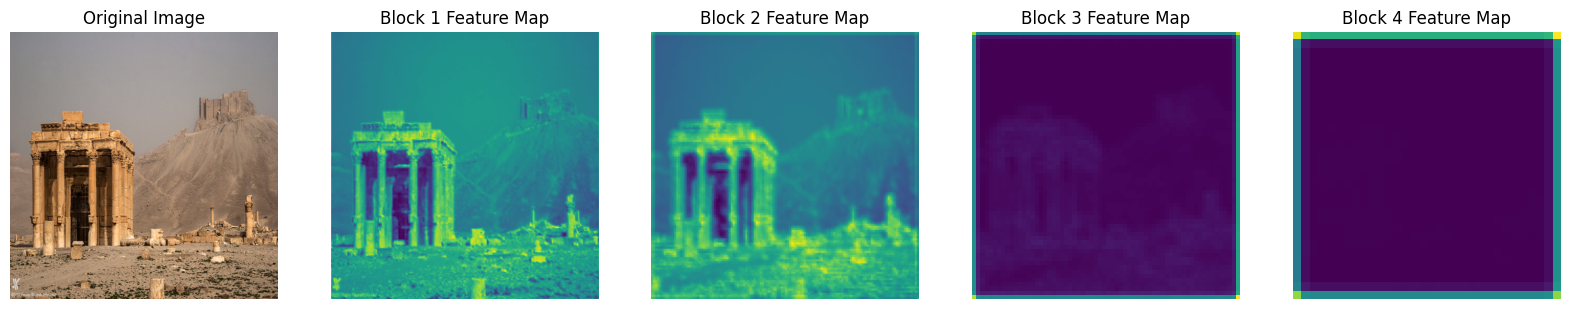

In [18]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go
from plotly.offline import plot


# Define the model classes
class ConvBlock(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList(
            [nn.Sequential(
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, 3, padding=1),
                nn.ReLU()
            ) for i in range(num_layers)]
        )
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.downsample(x)
        return x

class CNN(nn.Module):
    def __init__(self, in_channels, num_blocks, num_classes):
        super().__init__()
        first_channels = 64
        self.blocks = nn.ModuleList(
            [ConvBlock(
                2 if i == 0 else 3,
                in_channels=(in_channels if i == 0 else first_channels * (2**(i - 1))),
                out_channels=first_channels * (2**i))
             for i in range(num_blocks)]
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.cls = nn.Linear(first_channels * (2**(num_blocks - 1)), num_classes)

    def forward(self, x, return_features=False):
        features = []
        for block in self.blocks:
            x = block(x)
            features.append(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        logits = self.cls(x)
        if return_features:
            return logits, features
        return logits

# Load and preprocess the image
def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0)


transform_pixels = 512
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((transform_pixels, transform_pixels)),
    transforms.ToTensor()
])

# Initialize the model
model = CNN(3, 4, 10)

# Load a sample image
image_path = './data/train/multi-temporal-temple-baalshamin/images/070313_img_6187_syria_palmyra_roman_ruins_999x.png'
image = load_image(image_path, transform)

# Get the output and features from the model
model.eval()
with torch.no_grad():
    logits, features = model(image, return_features=True)

# Plot the original image and feature maps
def plot_features(image, features):
    fig, axs = plt.subplots(1, len(features) + 1, figsize=(20, 5))
    axs[0].imshow(image.permute(1, 2, 0).numpy())
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    for i, feature in enumerate(features):
        feature_map = feature.squeeze().mean(dim=0).cpu().numpy()
        axs[i + 1].imshow(feature_map, cmap='viridis')
        axs[i + 1].set_title(f'Block {i + 1} Feature Map')
        axs[i + 1].axis('off')

    plt.show()

# Plot the features
plot_features(image.squeeze(), features)


## Extract points

In [19]:
# Extract non-zero points from feature maps
def extract_points(features):
    points = []
    for i, feature in enumerate(features):
        nonzero_points = torch.nonzero(feature.squeeze() > feature.mean()).cpu().numpy()
        for point in nonzero_points:
            points.append((point[0], point[1], point[2], i))  # (x, y, z, layer)
    return points

# Plot points in 3D
def plot_3d(points):
    x, y, z, layer = zip(*points)
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color=layer,
            colorscale='Viridis',
            opacity=0.8
        )
    )
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        title='3D Feature Map Points'
    )
    fig = go.Figure(data=[trace], layout=layout)
    plot(fig)

# Extract points and plot in 3D
points = extract_points(features)
plot_3d(points)